# Iris Dataset Analysis

### AAEs Analysis

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from mlp_to_qbaf_converter.mlp_to_qbaf import MLPToQBAF
import Uncertainpy.src.uncertainpy.gradual as grad
from mlp_to_qbaf_converter.argument_attribution_explanation import AAE
from mlp_to_qbaf_converter.relation_attribution_explanation import RAE
from mlp_to_qbaf_converter.utils import plot_qbaf
from tqdm import tqdm
from scipy.stats import kendalltau, spearmanr
import joblib

We have trained MLP Classifers for the Iris dataset on various hidden layer sizes. We have then translated to QBAFs and computed the AAE gradient score for each of the above models and different levels of sparification. We have then compared the most important argument (neuron) between the sparsifed and original models, evaluating whether the most important neuron is the same in both models.

The sparsification levels are: 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%

In [2]:
max_argument_mlp_dict = {}
gradient_scores_dict = {}
rankings_dict = {}
removal_impacts_dict = {}


for mlp in Path("../../outputs/iris/aae").glob("*_gradient.npz"):

    file_name = mlp.stem
    # mlp_size1_size2_size3..._gradient.npz
    mlp_size = file_name.replace("_gradient","")
    print(mlp_size)

    data = np.load(mlp, allow_pickle=True)

    max_argument_mlp_dict[mlp_size] = data["max_arguments"]
    gradient_scores_dict[mlp_size] = data["top_scores"]
    rankings_dict[mlp_size] = data["rankings"]
    removal_impacts_dict[mlp_size] = data["impacts"]
    

mlp70
mlp70_200
mlp25_100
mlp200_70
mlp20
mlp3_4
mlp50_100
mlp100_100
mlp80_80
mlp25_25
mlp10_10
mlp200_25
mlp80
mlp200_50
mlp40_40
mlp30_30
mlp50
mlp40
mlp50_50
mlp20_20
mlp50_200
mlp10
mlp15_15
mlp65_65
mlp25_200
mlp100_50
mlp90_90
mlp45_45
mlp90
mlp35_35
mlp100
mlp5_5
mlp30
mlp100_25
mlp60


In [3]:
shrink_percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90]
header_shrink = [("Shrink", f"{percent}%") for percent in shrink_percentages]
results_df = pd.DataFrame(columns=[("", "Hidden Layers"), ("", "Total No. Neurons"), ("", "Depth")] + header_shrink)
results_df.columns = pd.MultiIndex.from_tuples(results_df.columns)
sizes = []
depths = []
totals = []

for i, mlp in enumerate(max_argument_mlp_dict):
    size = tuple(map(int, str(mlp)[3:].split("_")))
    sizes.append(size)
    depth = len(size)
    depths.append(depth)
    total_neurons = sum(size)
    totals.append(total_neurons)


    results_df.loc[i, ("", "Hidden Layers")] = str(size)
    results_df.loc[i, ("", "Total No. Neurons")] = total_neurons
    results_df.loc[i, ("", "Depth")] = depth

    results_df.loc[i, header_shrink] = max_argument_mlp_dict[mlp]

In [4]:
# from IPython.display import HTML
# HTML(results_df.style.set_table_styles(
#     [{'selector': 'th', 'props': [('text-align', 'center')]}]
# ).to_html(index=False))


results_df

Shrink                        \
   Hidden Layers Total No. Neurons Depth        10%        20%        30%   
0          (70,)                70     1  86.666667  77.777778  82.222222   
1      (70, 200)               270     2  73.333333  75.555556  71.111111   
2      (25, 100)               125     2  77.777778  68.888889  68.888889   
3      (200, 70)               270     2  82.222222  77.777778  77.777778   
4          (20,)                20     1      100.0      100.0      100.0   
5         (3, 4)                 7     2  55.555556  55.555556  66.666667   
6      (50, 100)               150     2  73.333333  73.333333  68.888889   
7     (100, 100)               200     2  75.555556  73.333333  75.555556   
8       (80, 80)               160     2  73.333333  77.777778  73.333333   
9       (25, 25)                50     2      100.0      100.0      100.0   
10      (10, 10)                20     2      100.0  48.888889  22.222222   
11     (200, 25)               225     2      100.0      100.0      100.0   
12         (80,)                80     1  86.666667  86.666667  84.444444   
13     (200, 50)               250     2  93.333333  93.333333  95.555556   
14      (40, 40)                80     2  95.555556  97.777778  97.777778   
15      (30, 30)                60     2  97.777778      100.0      100.0   
16         (50,)                50     1  82.222222  82.222222       80.0   
17         (40,)                40     1  77.777778  86.666667  77.777778   
18      (50, 50)               100     2  91.111111  93.333333  88.888889   
19      (20, 20)                40     2      100.0      100.0       80.0   
20     (50, 200)               250     2  64.444444  66.666667  64.444444   
21         (10,)                10     1      100.0      100.0  86.666667   
22      (15, 15)                30     2  82.222222  66.666667   2.222222   
23      (65, 65)               130     2  91.111111  93.333333  88.888889   
24     (25, 200)               225     2  68.888889  73.333333  66.666667   
25     (100, 50)               150     2  93.333333  95.555556  93.333333   
26      (90, 90)               180     2  82.222222  68.888889  68.888889   
27      (45, 45)                90     2  97.777778  95.555556  93.333333   
28         (90,)                90     1  88.888889  84.444444  93.333333   
29      (35, 35)                70     2  95.555556  95.555556  97.777778   
30        (100,)               100     1  86.666667  84.444444       80.0   
31        (5, 5)                10     2  64.444444  64.444444  62.222222   
32         (30,)                30     1  77.777778  75.555556       80.0   
33     (100, 25)               125     2  97.777778  97.777778  97.777778   
34         (60,)                60     1       80.0  77.777778  86.666667   

                                                                      
          40%        50%        60%        70%        80%        90%  
0   84.444444  77.777778  73.333333  24.444444        0.0        0.0  
1   75.555556  64.444444  62.222222  28.888889   6.666667   4.444444  
2   62.222222       40.0  33.333333   8.888889  13.333333   6.666667  
3   82.222222  82.222222       80.0  66.666667  31.111111   2.222222  
4   84.444444  66.666667  57.777778  48.888889  42.222222  17.777778  
5   66.666667  64.444444  97.777778  97.777778  97.777778  97.777778  
6   73.333333  64.444444  55.555556  31.111111   8.888889   4.444444  
7   73.333333  77.777778  66.666667  55.555556  28.888889   4.444444  
8   66.666667  71.111111       60.0  51.111111  15.555556   2.222222  
9   97.777778  68.888889       40.0        0.0        0.0        0.0  
10   2.222222        0.0        0.0        0.0        0.0        0.0  
11  97.777778  97.777778  57.777778  35.555556  13.333333        0.0  
12  91.111111       80.0  84.444444  51.111111        0.0   2.222222  
13  93.333333  93.333333  86.666667       80.0  46.666667        0.0  
14  91.111111  68.888889  35.555556   2.222222        0.0  

In [5]:
max_arg_results = []

for shrink_percentage in header_shrink:
    avg = results_df[shrink_percentage].mean()
    max_arg_results.append(avg)
    print(f"Average for {shrink_percentage[1]} Sparsification: {avg.mean()}")

print(f"Latex row: {"&".join([str(round(x, 1)) for x in max_arg_results])} \\\\")


Average for 10% Sparsification: 85.52380952380952
Average for 20% Sparsification: 83.11111111111111
Average for 30% Sparsification: 79.23809523809524
Average for 40% Sparsification: 75.93650793650792
Average for 50% Sparsification: 66.66666666666667
Average for 60% Sparsification: 54.66666666666668
Average for 70% Sparsification: 35.04761904761904
Average for 80% Sparsification: 14.412698412698415
Average for 90% Sparsification: 10.095238095238098
Latex row: 85.5&83.1&79.2&75.9&66.7&54.7&35.0&14.4&10.1 \\


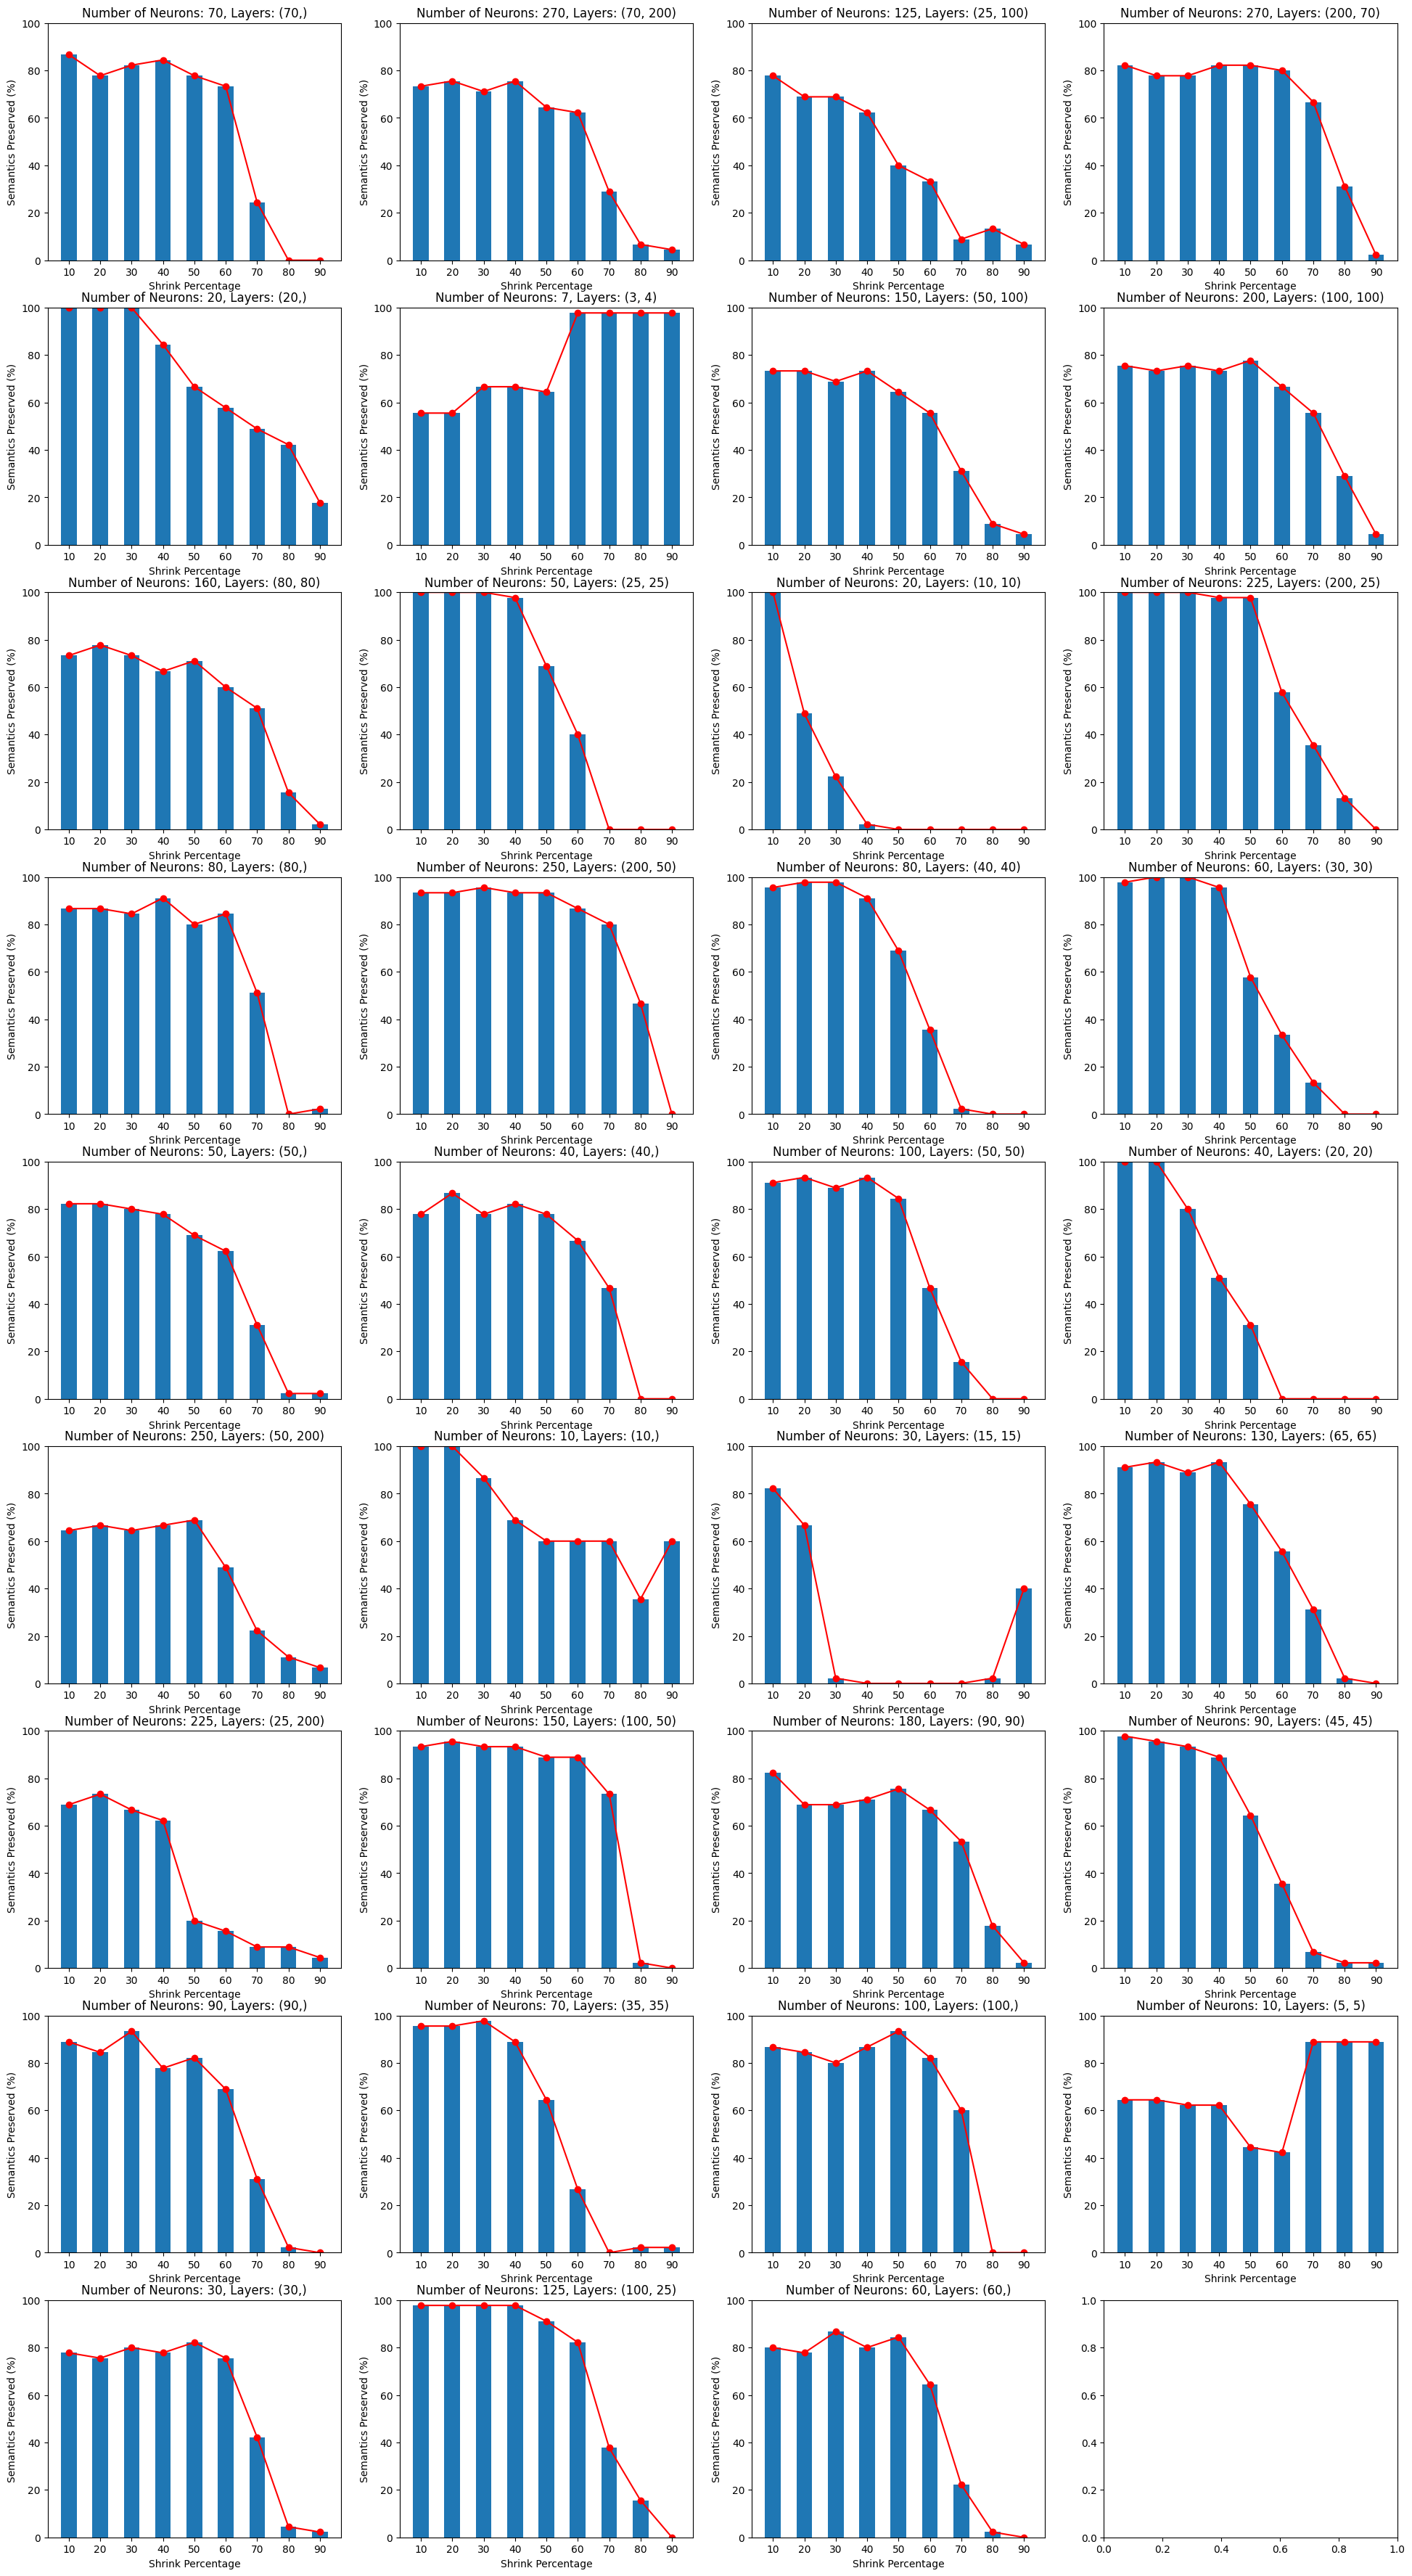

In [6]:
import math

num_sizes = len(sizes)
cols = min(4, math.ceil(math.sqrt(num_sizes)))
rows = math.ceil(num_sizes / cols)
fig, ax = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))

for i, size in enumerate(sizes):
    ax[i//cols, i%cols].bar(shrink_percentages, results_df.iloc[i, 3:], width=5)
    ax[i//cols, i%cols].plot(shrink_percentages, results_df.iloc[i, 3:], marker="o", color="red")
    ax[i//cols, i%cols].set_title(f"Number of Neurons: {totals[i]}, Layers: {size}")
    ax[i//cols, i%cols].set_xlabel("Shrink Percentage")
    ax[i//cols, i%cols].set_ylabel("Semantics Preserved (%)")
    ax[i//cols, i%cols].set_ylim(0, 100)
    ax[i//cols, i%cols].set_xticks(shrink_percentages)


In [7]:
# depths_unique = np.unique(depths)
# depths_unique_sorted_idx = np.argsort(depths_unique)
# depths_unique = depths_unique[depths_unique_sorted_idx]
# average_preserved_depth = np.zeros((len(depths_unique), len(shrink_percentages)))

# for i, depth in enumerate(depths_unique):
#     average_preserved_depth[i] = np.mean(results_df[results_df[("", "Depth")] == depth].iloc[:, 3:], axis=0)

# rows = math.ceil(math.sqrt(len(depths_unique)))
# cols = math.ceil(len(depths_unique) / rows)
# fig, ax = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))

# for i, depth in enumerate(depths_unique):
#     ax[i//cols, i%cols].bar(shrink_percentages, average_preserved_depth[i], width=5)
#     ax[i//cols, i%cols].plot(shrink_percentages, average_preserved_depth[i], marker="o", color="red")
#     ax[i//cols, i%cols].set_title(f"Depth (Number Hidden Layers): {depth}")
#     ax[i//cols, i%cols].set_xlabel("Shrink Percentage")
#     ax[i//cols, i%cols].set_ylabel("Semantics Preserved Average (%)")
#     ax[i//cols, i%cols].set_ylim(0, 100)
#     ax[i//cols, i%cols].set_xticks(shrink_percentages)

# plt.show()

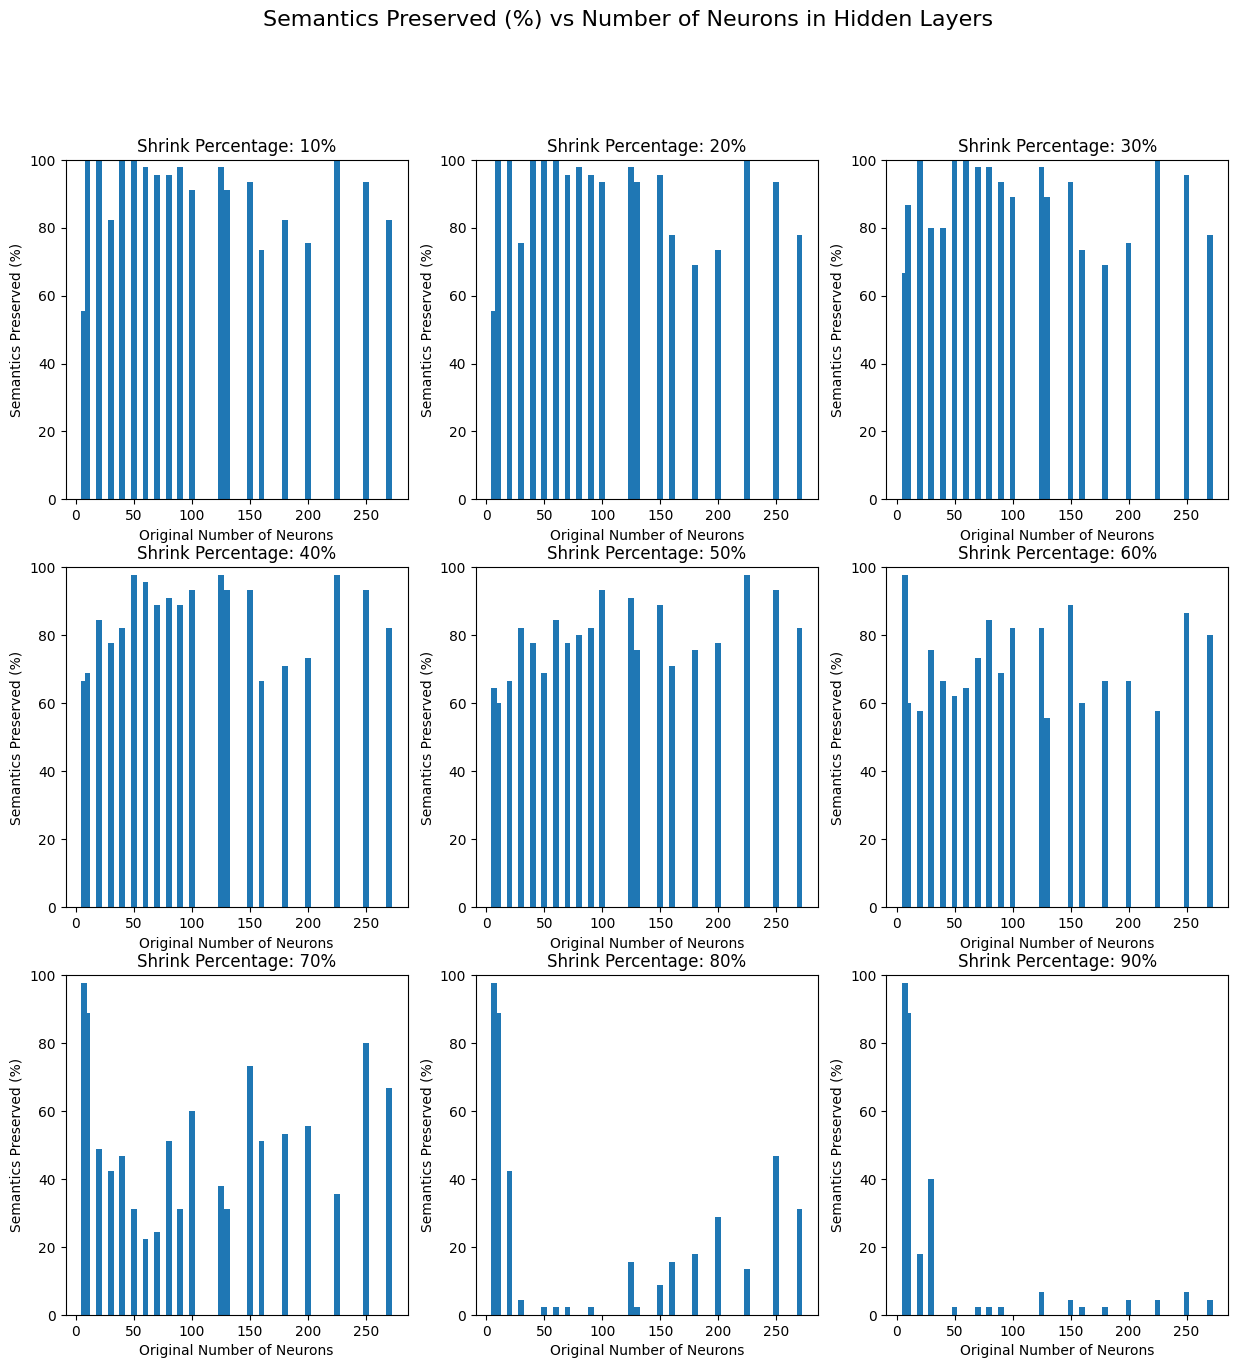

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, figsize=(15, 15))

totals_sorted_idx = np.argsort(totals)
totals_sorted = np.array(totals)[totals_sorted_idx]

for i, shrink_percentage in enumerate(shrink_percentages):

    percents = results_df.iloc[:, i+3].to_numpy()[totals_sorted_idx]
    
    ax[i//3, i%3].bar(totals_sorted, percents, width=5)
    # ax[i//3, i%3].plot(totals_sorted, percents, marker="o", color="red", linewidth=0.5, markersize=2)
    ax[i//3, i%3].set_title(f"Shrink Percentage: {shrink_percentage}%")
    ax[i//3, i%3].set_xlabel("Original Number of Neurons")
    ax[i//3, i%3].set_ylabel("Semantics Preserved (%)")
    ax[i//3, i%3].set_ylim(0, 100)

# fig.tight_layout()
fig.suptitle("Semantics Preserved (%) vs Number of Neurons in Hidden Layers", fontsize=16)
plt.show()


Further ideas:
<!-- - Track back the most important argument in the sparsifed network to see how much each of the input features contributed to this () -->
- Repeat using other types of AAE (e.g. removal scores)
- Repeat on other datasets, see if we get similar results (maybe later)
- Repeat this style of analysis on RAEs (time complexity issues for SHAP scores if MLPs are large)
- Start researching LRP to find some metrics to check faithfulness of explanations
    - Removal of neurons -> removing the most important neuron should have the biggest impact on the output
    - Perturbation of neurons -> perturbing the most important neuron should have the biggest impact on the output
    - Compare the faithfulness of the explanations before and after sparsification



- Coefficient $\checkmark$
- Ranking (weighting) -> score for cluster and original average
- AAEs
- Other AAE types

In [9]:
kendalltau_coeffs_dict = {}
spearman_coeffs_dict = {}

for mlp in gradient_scores_dict:
    kendalltau_coeffs = np.zeros(((gradient_scores_dict[mlp].shape[0], gradient_scores_dict[mlp].shape[1] - 1)), dtype=float)
    spearman_coeffs = np.zeros(((gradient_scores_dict[mlp].shape[0], gradient_scores_dict[mlp].shape[1] - 1)), dtype=float)
    top_scores = gradient_scores_dict[mlp]
    for example in range(top_scores.shape[0]):
        for sparse_percent in range(1, top_scores.shape[1]):
            kendalltau_coeffs[example, sparse_percent - 1] = kendalltau(np.abs(top_scores[example, 0]), np.abs(top_scores[example, sparse_percent]))[0]
            spearman_coeffs[example, sparse_percent - 1] = spearmanr(np.abs(top_scores[example, 0]), np.abs(top_scores[example, sparse_percent]))[0]

            # Deal with the case where the top scores are the same
            # If the top scores are all the same, then the correlation is 1
            # Otherwise, it is 0
            if np.isnan(kendalltau_coeffs[example, sparse_percent - 1]):
                if np.all(top_scores[example, 0] == top_scores[example, sparse_percent]):
                    kendalltau_coeffs[example, sparse_percent - 1] = 1.0
                else:
                    kendalltau_coeffs[example, sparse_percent - 1] = 0.0
            
            if np.isnan(spearman_coeffs[example, sparse_percent - 1]):
                if np.all(top_scores[example, 0] == top_scores[example, sparse_percent]):
                    spearman_coeffs[example, sparse_percent - 1] = 1.0
                else:
                    spearman_coeffs[example, sparse_percent - 1] = 0.0

    kendalltau_coeffs_dict[mlp] = kendalltau_coeffs
    spearman_coeffs_dict[mlp] = spearman_coeffs
    

/tmp/ipykernel_2706861/912873563.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_coeffs[example, sparse_percent - 1] = spearmanr(np.abs(top_scores[example, 0]), np.abs(top_scores[example, sparse_percent]))[0]


In [10]:

headers = ["MLP Shape", "Number of Neurons"] + [f"{percent}%" for percent in shrink_percentages]
kendalltaucoefficients_df = pd.DataFrame(columns=headers)

for mlp in kendalltau_coeffs_dict:
    hidden_layers = tuple(map(int, (mlp[3:].split("_"))))
    row = [hidden_layers, sum(hidden_layers)]
    row.extend(list(np.mean(kendalltau_coeffs_dict[mlp], axis=0)))
    kendalltaucoefficients_df.loc[len(kendalltaucoefficients_df)] = row

kendalltaucoefficients_df.sort_values("Number of Neurons", inplace=True)

In [11]:
kendalltaucoefficients_df.aggregate({h: ["mean", "max", "min"] for h in headers[2:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,0.826201,0.817162,0.812109,0.800152,0.799383,0.789337,0.776072,0.774387,0.783536
max,0.987973,0.981324,0.984738,0.979611,0.995922,0.995922,0.995922,0.995922,0.995922
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [12]:
headers = ["MLP Shape", "Number of Neurons"] + [f"{percent}%" for percent in shrink_percentages]
spearman_coefficients_df = pd.DataFrame(columns=headers)

for mlp in spearman_coeffs_dict:
    hidden_layers = tuple(map(int, (mlp[3:].split("_"))))
    row = [hidden_layers, sum(hidden_layers)]
    row.extend(list(np.mean(spearman_coeffs_dict[mlp], axis=0)))
    spearman_coefficients_df.loc[len(spearman_coefficients_df)] = row

spearman_coefficients_df.sort_values("Number of Neurons", inplace=True)

In [13]:
spearman_coefficients_df.aggregate({h: ["mean", "max", "min"] for h in headers[2:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,0.833556,0.824695,0.820530,0.808665,0.809198,0.799067,0.786049,0.786093,0.798074
max,0.993027,0.988764,0.988797,0.985114,0.997023,0.997023,0.997023,0.997023,0.997023
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


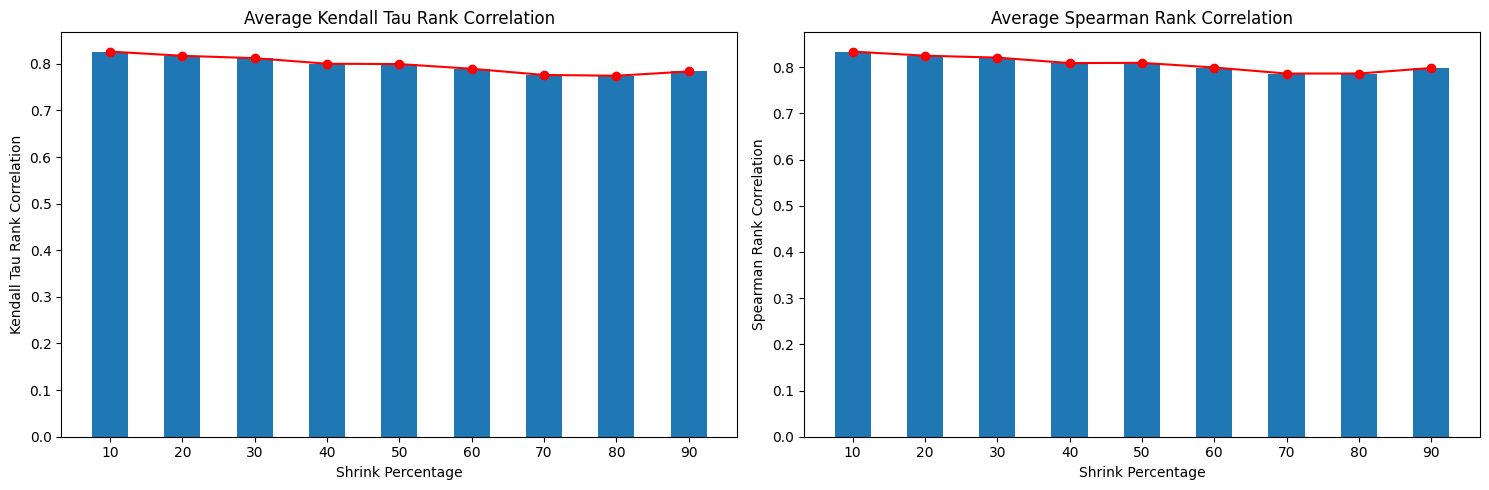

In [14]:
average_kendalltau_ranks = np.zeros((len(shrink_percentages)))

for mlp in kendalltau_coeffs_dict:
    average_kendalltau_ranks += np.mean(kendalltau_coeffs_dict[mlp], axis=0)

average_kendalltau_ranks /= len(kendalltau_coeffs_dict)

average_spearman_ranks = np.zeros((len(shrink_percentages)))

for mlp in spearman_coeffs_dict:
    average_spearman_ranks += np.mean(spearman_coeffs_dict[mlp], axis=0)

average_spearman_ranks /= len(spearman_coeffs_dict)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].bar(shrink_percentages, average_kendalltau_ranks, width=5)
ax[0].plot(shrink_percentages, average_kendalltau_ranks, marker="o", color="red")
ax[0].set_title("Average Kendall Tau Rank Correlation")
ax[0].set_xlabel("Shrink Percentage")
ax[0].set_ylabel("Kendall Tau Rank Correlation")
# ax[0].set_ylim(0, 1)
ax[0].set_xticks(shrink_percentages)
# ax[0].axhline(0, color="black")

ax[1].bar(shrink_percentages, average_spearman_ranks, width=5)
ax[1].plot(shrink_percentages, average_spearman_ranks, marker="o", color="red")
ax[1].set_title("Average Spearman Rank Correlation")
ax[1].set_xlabel("Shrink Percentage")
ax[1].set_ylabel("Spearman Rank Correlation")
# ax[1].set_ylim(0, 1)
ax[1].set_xticks(shrink_percentages)
plt.tight_layout()
plt.show()

In [15]:
shrink_percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90]
top_n_same = np.zeros((len(rankings_dict), len(shrink_percentages)))
top_in_top_n = np.zeros((len(rankings_dict), len(shrink_percentages)))
pearson_coeffs = np.zeros((len(rankings_dict), len(shrink_percentages)))
kendalltau_coeffs = np.zeros((len(rankings_dict), len(shrink_percentages)))
rankings_diff = np.zeros((len(rankings_dict), len(shrink_percentages)))
for m, mlp in enumerate(rankings_dict):
    top_n_same_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages))) 
    top_in_top_n_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    pearson_coeffs_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    kendalltau_coeffs_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    rankings_diff_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    for example in range(len(rankings_dict[mlp])):
        for sparse_percent in range(len(rankings_dict[mlp][example])):
            original_scores = rankings_dict[mlp][example][sparse_percent, 0]
            original_scores[:, 1] = np.abs(np.astype(original_scores[:, 1], float))
            sparse_scores = rankings_dict[mlp][example][sparse_percent, 1]
            sparse_scores[:, 1] = np.abs(np.astype(sparse_scores[:, 1], float))
            count_same_rankings = 0
            original_scores_sorted = np.array(sorted(original_scores, key=lambda x: float(x[1]), reverse=True))
            sparse_scores_sorted = np.array(sorted(sparse_scores, key=lambda x: float(x[1]), reverse=True))
            top_n = min(10, len(sparse_scores_sorted) // 2)
            for i in range(top_n):
                if original_scores_sorted[i, 0] in sparse_scores_sorted[:top_n, 0]:
                    count_same_rankings += 1
            top_n_same_tmp[example, sparse_percent] = count_same_rankings / top_n * 100

            if original_scores_sorted[0, 0] in sparse_scores_sorted[:top_n, 0]:
                top_in_top_n_tmp[example, sparse_percent] = 1
            
            for i in range(len(original_scores_sorted)):
                clustered_i = np.argwhere(sparse_scores_sorted[:, 0] == original_scores_sorted[i, 0])
                if len(clustered_i) == 0:
                    raise ValueError("Could not find the argument in the sparse scores")
                clustered_i = clustered_i[0][0]
                rankings_diff_tmp[example, sparse_percent] += abs(i - clustered_i) / len(original_scores_sorted) * 100
            
            rankings_diff_tmp[example, sparse_percent] /= len(original_scores_sorted)

            original_scores_sorted = np.array(sorted(original_scores, key=lambda x: x[1], reverse=True))
            sparse_scores_sorted = np.array(sorted(sparse_scores, key=lambda x: x[1], reverse=True))

            pearson_coeffs_tmp[example, sparse_percent] = spearmanr([float(x[1]) for x in original_scores_sorted], [float(x[1]) for x in sparse_scores_sorted])[0]
            kendalltau_coeffs_tmp[example, sparse_percent] = kendalltau([float(x[1]) for x in original_scores_sorted], [float(x[1]) for x in sparse_scores_sorted])[0]
    top_in_top_n[m] = np.mean(top_in_top_n_tmp, axis=0) * 100
    pearson_coeffs[m] = np.mean(pearson_coeffs_tmp, axis=0)
    top_n_same[m] = np.mean(top_n_same_tmp, axis=0)
    kendalltau_coeffs[m] = np.mean(kendalltau_coeffs_tmp, axis=0)
    rankings_diff[m] = np.mean(rankings_diff_tmp, axis=0)


/tmp/ipykernel_2706861/11805857.py:43: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_coeffs_tmp[example, sparse_percent] = spearmanr([float(x[1]) for x in original_scores_sorted], [float(x[1]) for x in sparse_scores_sorted])[0]


In [16]:
headers = ["MLP Shape", "Number of Neurons", "Number of Hidden Layers"] + [f"{percent}%" for percent in shrink_percentages]
top_n_same_df = pd.DataFrame(columns=headers)
top_n_same_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
top_n_same_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
top_n_same_df["Number of Hidden Layers"] = [len(x) for x in top_n_same_df["MLP Shape"]]
top_n_same_df[headers[3:]] = top_n_same
top_n_same_df.sort_values("Number of Neurons", inplace=True)

In [17]:
top_n_same_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,63.032200,57.720635,59.227513,61.197531,63.941270,66.841119,68.915848,72.562283,74.534467
max,95.555556,95.873016,91.555556,89.444444,89.444444,87.777778,87.777778,87.777778,87.777778
min,39.111111,37.111111,39.555556,41.777778,42.444444,41.333333,42.666667,40.666667,51.666667


In [18]:
rankings_diff_df = pd.DataFrame(columns=headers)
rankings_diff_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
rankings_diff_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
rankings_diff_df["Number of Hidden Layers"] = [len(x) for x in rankings_diff_df["MLP Shape"]]
rankings_diff_df[headers[3:]] = rankings_diff
rankings_diff_df.sort_values("Number of Neurons", inplace=True)


In [19]:
rankings_diff_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,7.888662,10.062860,11.655825,12.306150,12.705436,12.867824,13.163495,13.697300,16.354008
max,12.190593,14.832256,17.112188,17.264198,18.056973,18.277673,18.750000,20.800000,27.708333
min,2.955601,4.292211,4.755556,3.786008,3.950617,6.375868,6.358500,7.013889,7.013889


In [20]:
top_in_top_n_df = pd.DataFrame(columns=headers)
top_in_top_n_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
top_in_top_n_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
top_in_top_n_df["Number of Hidden Layers"] = [len(x) for x in top_in_top_n_df["MLP Shape"]]
top_in_top_n_df[headers[3:]] = top_in_top_n
top_in_top_n_df.sort_values("Number of Neurons", inplace=True)

In [21]:
top_in_top_n_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,95.428571,95.492063,95.936508,95.301587,94.920635,95.238095,96.000000,96.380952,92.698413
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
min,82.222222,80.000000,82.222222,82.222222,80.000000,77.777778,84.444444,84.444444,6.666667


In [22]:
pearson_coeffs_df = pd.DataFrame(columns=headers)
pearson_coeffs_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
pearson_coeffs_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
pearson_coeffs_df["Number of Hidden Layers"] = [len(x) for x in pearson_coeffs_df["MLP Shape"]]
pearson_coeffs_df[headers[3:]] = pearson_coeffs
pearson_coeffs_df.sort_values("Number of Neurons", inplace=True)

In [23]:
pearson_coeffs_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,0.906624,0.893530,0.881563,0.870991,0.867135,0.856890,0.853761,0.858845,0.859054
max,0.997920,0.997920,0.999661,1.000000,1.000000,0.992412,0.993515,0.993515,0.994294
min,0.733886,0.661549,0.661685,0.644155,0.623647,0.603916,0.617719,0.608718,0.528676


In [24]:
kendalltau_coeffs_df = pd.DataFrame(columns=headers)
kendalltau_coeffs_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
kendalltau_coeffs_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
kendalltau_coeffs_df["Number of Hidden Layers"] = [len(x) for x in kendalltau_coeffs_df["MLP Shape"]]
kendalltau_coeffs_df[headers[3:]] = kendalltau_coeffs
kendalltau_coeffs_df.sort_values("Number of Neurons", inplace=True)


In [25]:
kendalltau_coeffs_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,10%,20%,30%,40%,50%,60%,70%,80%,90%
mean,0.904045,0.892518,0.882367,0.871970,0.867809,0.857554,0.852606,0.854675,0.847870
max,0.993205,0.993205,0.998730,1.000000,1.000000,0.992929,0.986578,0.986578,0.986578
min,0.749089,0.686545,0.695425,0.681168,0.664081,0.645024,0.657442,0.643926,0.483250


#### Creating a faithfulness score

In SpArX, evalaute faithfulness using a structural faithfulness score and input-output faithfuless. 

Do something similar by looking at the impact of removal of the most important argument on the strength of the topic argument. If the strength after removal is roughly the same in both then this shows the sparsification is faithful (similar to input/output faithfulness).

Structural faithfulness: Create a score based on how close the averaged rankings are to the sparse rankings -> large difference = lower structural faithfulness.

Next steps: Compare to ML methods -> just compute AAEs on input arguments

### RAEs Analysis

![RAE Illustration](RAE_Illustration.png)


In [26]:
rankings_dict = {}
rankings_variances_dict = {}
rankings_weighted_dict = {}
non_averaged_rankings_percents = {}
non_averaged_kendalltau_coeffs_dict = {}
non_averaged_pearson_coeffs_dict = {}

for mlp in Path("../../outputs/iris/rae").glob("*_shap.npz"):

    file_name = mlp.stem
    # mlp_size1_size2_size3..._gradient.npz
    mlp_size = file_name.replace("_shap","")
    print(mlp_size)

    data = np.load(mlp, allow_pickle=True)

    rankings_dict[mlp_size] = data["rankings"]

    try:
        non_averaged_rankings_percents[mlp_size] = data["non_averaged_rankings"]
        rankings_weighted_dict[mlp_size] = data["rankings_weighted"]
        rankings_variances_dict[mlp_size] = data["rankings_variances"]
        non_averaged_kendalltau_coeffs_dict[mlp_size] = data["kendall_taus"]
        non_averaged_pearson_coeffs_dict[mlp_size] = data["pearson_correlations"]
    except Exception:
        # Haven't been calculated yet
        continue

mlp5_10
mlp8_8
mlp6_6
mlp8
mlp7
mlp3_50
mlp3_20
mlp2_2
mlp5_5
mlp6
mlp9
mlp10_2
mlp2_50
mlp5
mlp30
mlp2_40
mlp10
mlp7_7
mlp2_10
mlp10_10
mlp2
mlp10_5
mlp9_9
mlp40
mlp2_30
mlp50
mlp2_20
mlp4_4
mlp3_3
mlp4
mlp3


In [27]:
def remove_relation_type(arr):
    for i in range(len(arr)):
        if "Attack" in arr[i]:
            arr[i] = arr[i].replace("Attack(", "").replace(")", "")
        else:
            arr[i] = arr[i].replace("Support(", "").replace(")", "")

    return arr 

shrink_percentages = [20, 40, 60, 80]
top_n_same = np.zeros((len(rankings_dict), len(shrink_percentages)))
top_in_top_n = np.zeros((len(rankings_dict), len(shrink_percentages)))
pearson_coeffs = np.zeros((len(rankings_dict), len(shrink_percentages)))
kendalltau_coeffs = np.zeros((len(rankings_dict), len(shrink_percentages)))
rankings_diff = np.zeros((len(rankings_dict), len(shrink_percentages)))
for m, mlp in enumerate(rankings_dict):
    top_n_same_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages))) 
    top_in_top_n_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    pearson_coeffs_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    kendalltau_coeffs_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    rankings_diff_tmp = np.zeros((len(rankings_dict[mlp]), len(shrink_percentages)))
    for example in range(len(rankings_dict[mlp])):
        for sparse_percent in range(len(rankings_dict[mlp][example])):
            original_scores = rankings_dict[mlp][example][sparse_percent, 0]
            original_scores[:, 1] = np.abs(np.astype(original_scores[:, 1], float))
            sparse_scores = rankings_dict[mlp][example][sparse_percent, 1]
            sparse_scores[:, 1] = np.abs(np.astype(sparse_scores[:, 1], float))
            sparse_scores[:, 0] = remove_relation_type(sparse_scores[:, 0])
            count_same_rankings = 0
            original_scores_sorted = np.array(sorted(original_scores, key=lambda x: float(x[1]), reverse=True))
            sparse_scores_sorted = np.array(sorted(sparse_scores, key=lambda x: float(x[1]), reverse=True))
            top_n = min(10, len(sparse_scores_sorted) // 2)
            for i in range(top_n):
                if original_scores_sorted[i, 0] in sparse_scores_sorted[:top_n, 0]:
                    count_same_rankings += 1
            top_n_same_tmp[example, sparse_percent] = count_same_rankings / top_n * 100

            if original_scores_sorted[0, 0] in sparse_scores_sorted[:top_n, 0]:
                top_in_top_n_tmp[example, sparse_percent] = 1
            
            for i in range(len(original_scores_sorted)):
                clustered_i = np.argwhere(sparse_scores_sorted[:, 0] == original_scores_sorted[i, 0])
                if len(clustered_i) == 0:
                    raise ValueError("Could not find the argument in the sparse scores")
                clustered_i = clustered_i[0][0]
                rankings_diff_tmp[example, sparse_percent] += abs(i - clustered_i) / len(original_scores_sorted) * 100
            
            rankings_diff_tmp[example, sparse_percent] /= len(original_scores_sorted)

            original_scores_sorted = np.array(sorted(original_scores, key=lambda x: x[1], reverse=True))
            sparse_scores_sorted = np.array(sorted(sparse_scores, key=lambda x: x[1], reverse=True))

            pearson_coeffs_tmp[example, sparse_percent] = spearmanr([float(x[1]) for x in original_scores_sorted], [float(x[1]) for x in sparse_scores_sorted])[0]
            kendalltau_coeffs_tmp[example, sparse_percent] = kendalltau([float(x[1]) for x in original_scores_sorted], [float(x[1]) for x in sparse_scores_sorted])[0]
    
    top_in_top_n[m] = np.mean(top_in_top_n_tmp, axis=0) * 100
    pearson_coeffs[m] = np.mean(pearson_coeffs_tmp, axis=0)
    top_n_same[m] = np.mean(top_n_same_tmp, axis=0)
    kendalltau_coeffs[m] = np.mean(kendalltau_coeffs_tmp, axis=0)
    rankings_diff[m] = np.mean(rankings_diff_tmp, axis=0)

Defining Preservation:
- Does the disribution of the RAEs stay the same? KL Divergence/ Wasserstein distance 
- Are the highest ranked relations the same? When the scores of the corresponding relations are averaged, do the top relations stay the same?

In [28]:
headers = ["MLP Shape", "Number of Neurons", "Number of Hidden Layers"] + [f"{percent}%" for percent in shrink_percentages]
top_n_same_df = pd.DataFrame(columns=headers)
top_n_same_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
top_n_same_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
top_n_same_df["Number of Hidden Layers"] = [len(x) for x in top_n_same_df["MLP Shape"]]
top_n_same_df[headers[3:]] = top_n_same
top_n_same_df.sort_values("Number of Neurons", inplace=True)

top_n_same_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,27.525971,31.944188,39.574558,38.631280
max,65.432099,70.370370,66.349206,69.876543
min,2.888889,3.111111,9.111111,14.444444


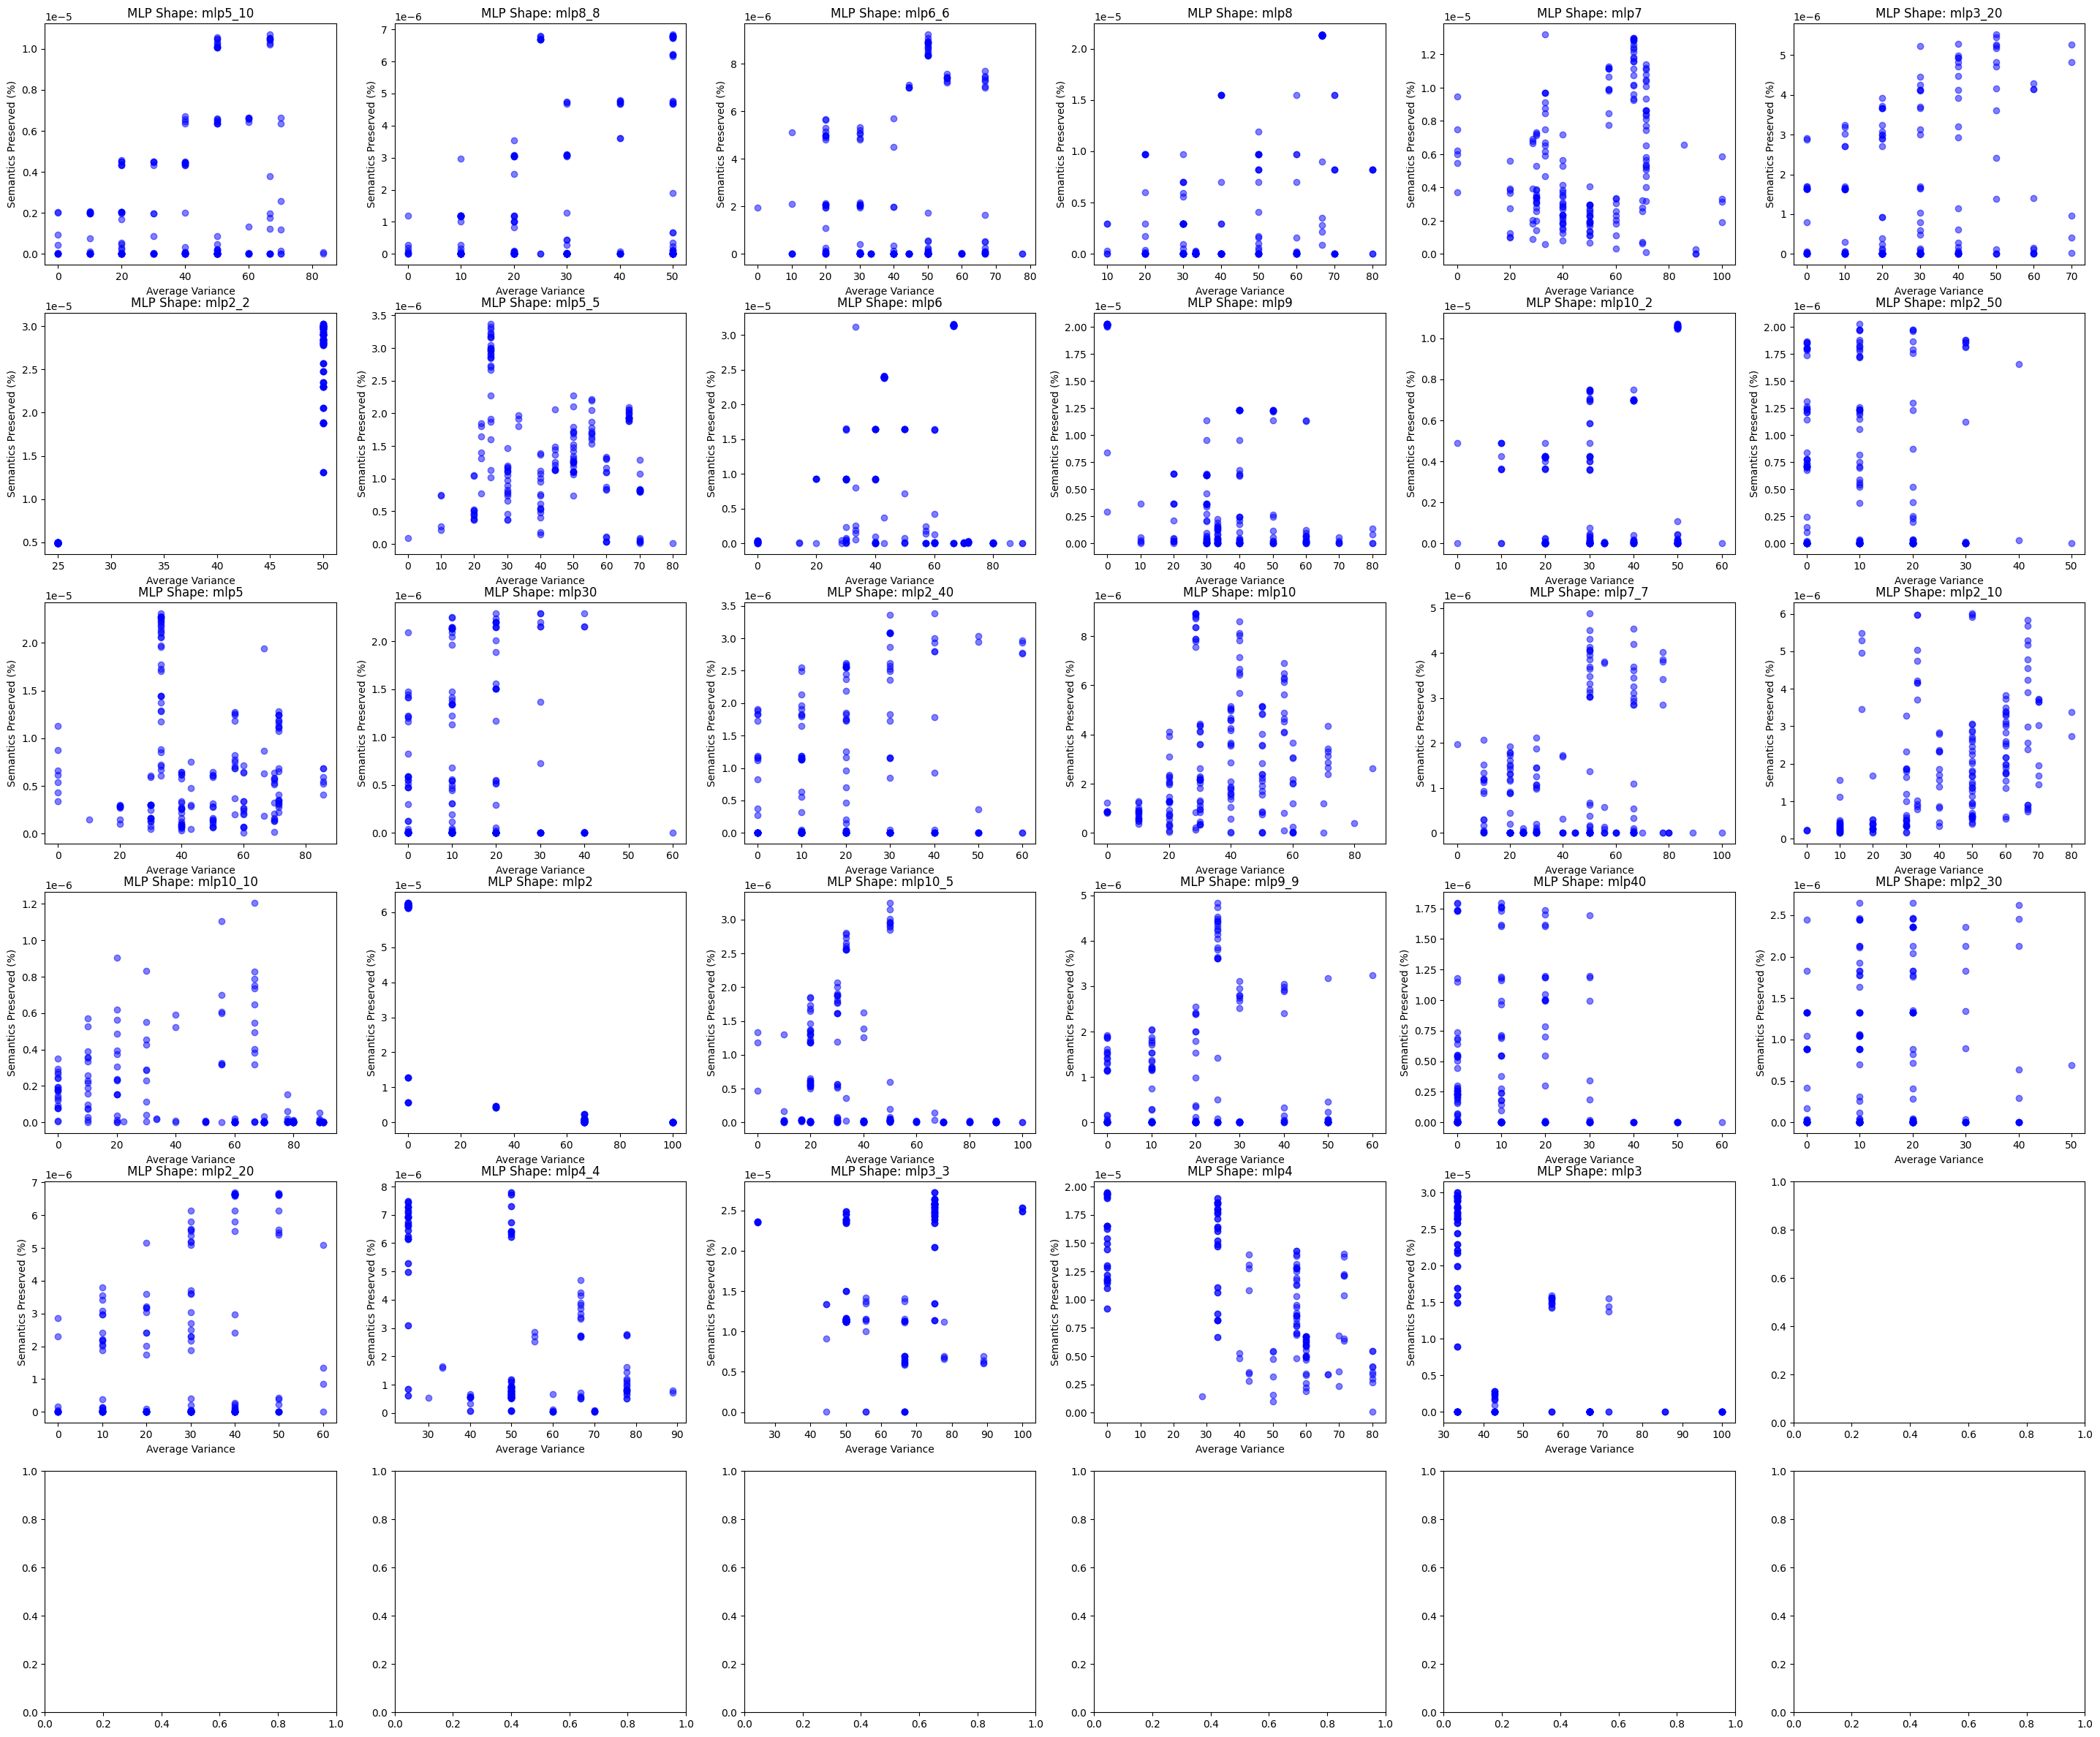

In [29]:
rows = math.ceil(math.sqrt(len(rankings_dict)))
cols = math.ceil(len(rankings_dict) / rows)

fig, ax = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))

mean_variances = np.zeros((len(rankings_variances_dict), len(shrink_percentages)))

for m, mlp in enumerate(rankings_variances_dict):
    var_dict_tmp = np.zeros((len(rankings_variances_dict[mlp]), len(shrink_percentages)))
    avg_variances = []
    avg_preservations = []
    for example in range(len(rankings_variances_dict[mlp])):
        for sparse_percent in range(len(rankings_variances_dict[mlp][example])):
            # Convert the data to float before calculating the mean
            variances = rankings_variances_dict[mlp][example][sparse_percent, 0][:, 1].astype(float)
            avg_variance = np.mean(variances)

            original_scores = rankings_dict[mlp][example][sparse_percent, 0]
            original_scores[:, 1] = np.abs(np.astype(original_scores[:, 1], float))
            sparse_scores = rankings_dict[mlp][example][sparse_percent, 1]
            sparse_scores[:, 1] = np.abs(np.astype(sparse_scores[:, 1], float))
            sparse_scores[:, 0] = remove_relation_type(sparse_scores[:, 0])
            count_same_rankings = 0
            original_scores_sorted = np.array(sorted(original_scores, key=lambda x: float(x[1]), reverse=True))
            sparse_scores_sorted = np.array(sorted(sparse_scores, key=lambda x: float(x[1]), reverse=True))
            top_n = min(10, len(sparse_scores_sorted) // 2)
            for i in range(top_n):
                if original_scores_sorted[i, 0] in sparse_scores_sorted[:top_n, 0]:
                    count_same_rankings += 1

            preservation = count_same_rankings / top_n * 100

            avg_variances.append(avg_variance)
            avg_preservations.append(preservation)

            var_dict_tmp[example, sparse_percent] = avg_variance
    
    mean_variances[m] = np.mean(var_dict_tmp, axis=0)

    ax[m//cols, m%cols].scatter(avg_preservations, avg_variances, color="blue", alpha=0.5)
    ax[m//cols, m%cols].set_title(f"MLP Shape: {mlp}")
    ax[m//cols, m%cols].set_xlabel("Average Variance")
    ax[m//cols, m%cols].set_ylabel("Semantics Preserved (%)")
    # ax[m//cols, m%cols].set_ylim(0, 100)
            
plt.show()

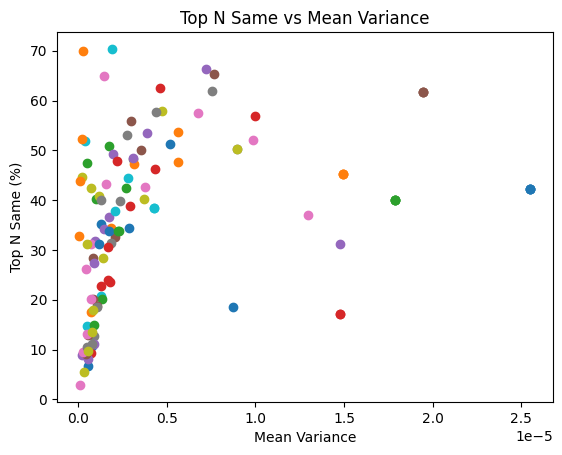

In [30]:
headers = ["MLP Shape", "Number of Neurons", "Number of Hidden Layers"] + [f"{percent}%" for percent in shrink_percentages]
rankings_variances_df = pd.DataFrame(columns=headers)
rankings_variances_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_variances_dict]
rankings_variances_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_variances_dict]
rankings_variances_df["Number of Hidden Layers"] = [len(x) for x in rankings_variances_df["MLP Shape"]]
rankings_variances_df[headers[3:]] = mean_variances
rankings_variances_df.sort_values("Number of Neurons", inplace=True)

for mlp in rankings_variances_df["MLP Shape"]:
    
    plt.scatter(rankings_variances_df[rankings_variances_df["MLP Shape"] == mlp].iloc[:, 3:].to_numpy()[0], top_n_same_df[top_n_same_df["MLP Shape"] == mlp].iloc[:, 3:].to_numpy()[0])


plt.xlabel("Mean Variance")
plt.ylabel("Top N Same (%)")
plt.title("Top N Same vs Mean Variance")

plt.show()

In [31]:
rankings_diff_df = pd.DataFrame(columns=headers)
rankings_diff_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
rankings_diff_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
rankings_diff_df["Number of Hidden Layers"] = [len(x) for x in rankings_diff_df["MLP Shape"]]
rankings_diff_df[headers[3:]] = rankings_diff
rankings_diff_df.sort_values("Number of Neurons", inplace=True)

rankings_diff_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})


,20%,40%,60%,80%
mean,30.398518,30.713759,30.828210,32.976035
max,34.203546,35.800429,40.362812,43.356009
min,21.632373,19.794239,21.041667,21.041667


In [32]:
top_in_top_n_df = pd.DataFrame(columns=headers)
top_in_top_n_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
top_in_top_n_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
top_in_top_n_df["Number of Hidden Layers"] = [len(x) for x in top_in_top_n_df["MLP Shape"]]
top_in_top_n_df[headers[3:]] = top_in_top_n
top_in_top_n_df.sort_values("Number of Neurons", inplace=True)

top_in_top_n_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,39.21147,41.362007,52.186380,41.146953
max,100.00000,100.000000,100.000000,100.000000
min,0.00000,0.000000,4.444444,0.000000


In [33]:
pearson_coeffs_df = pd.DataFrame(columns=headers)
pearson_coeffs_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
pearson_coeffs_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
pearson_coeffs_df["Number of Hidden Layers"] = [len(x) for x in pearson_coeffs_df["MLP Shape"]]
pearson_coeffs_df[headers[3:]] = pearson_coeffs
pearson_coeffs_df.sort_values("Number of Neurons", inplace=True)

pearson_coeffs_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,0.843751,0.813132,0.810081,0.85660
max,1.000000,1.000000,1.000000,1.00000
min,0.593759,0.543869,0.511979,0.54127


In [34]:
kendalltau_coeffs_df = pd.DataFrame(columns=headers)
kendalltau_coeffs_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in rankings_dict]
kendalltau_coeffs_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in rankings_dict]
kendalltau_coeffs_df["Number of Hidden Layers"] = [len(x) for x in kendalltau_coeffs_df["MLP Shape"]]
kendalltau_coeffs_df[headers[3:]] = kendalltau_coeffs
kendalltau_coeffs_df.sort_values("Number of Neurons", inplace=True)

kendalltau_coeffs_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,0.885106,0.864363,0.861551,0.892402
max,1.000000,1.000000,1.000000,1.000000
min,0.720835,0.688126,0.656432,0.641270


In [35]:
average_top_same_df = pd.DataFrame(columns=headers)
average_top_same_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in non_averaged_rankings_percents]
average_top_same_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in non_averaged_rankings_percents]
average_top_same_df["Number of Hidden Layers"] = [len(x) for x in average_top_same_df["MLP Shape"]]
average_top_same_df[headers[3:]] = [np.mean(non_averaged_rankings_percents[x], axis=0) for x in non_averaged_rankings_percents]
average_top_same_df.sort_values("Number of Neurons", inplace=True)

average_top_same_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,14.022302,12.941059,15.736152,15.553905
max,84.444444,60.370370,34.027778,35.555556
min,0.000000,0.000000,0.000000,0.000000


In [36]:
non_averaged_kendall = np.zeros((len(non_averaged_kendalltau_coeffs_dict), len(shrink_percentages)))

for m, mlp in enumerate(non_averaged_kendalltau_coeffs_dict):

    non_averaged_kendall[m] = np.mean(non_averaged_kendalltau_coeffs_dict[mlp].squeeze(), axis=0)

non_averaged_kendall_df = pd.DataFrame(columns=headers)
non_averaged_kendall_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in non_averaged_kendalltau_coeffs_dict]
non_averaged_kendall_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in non_averaged_kendalltau_coeffs_dict]
non_averaged_kendall_df["Number of Hidden Layers"] = [len(x) for x in non_averaged_kendall_df["MLP Shape"]]
non_averaged_kendall_df[headers[3:]] = non_averaged_kendall
non_averaged_kendall_df.sort_values("Number of Neurons", inplace=True)

In [37]:
non_averaged_kendall_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,0.987319,0.979488,0.967774,0.930766
max,0.996755,0.992376,0.988871,0.983675
min,0.956573,0.932255,0.911322,0.813553


In [38]:
non_averaged_pearson = np.zeros((len(non_averaged_pearson_coeffs_dict), len(shrink_percentages)))

for m, mlp in enumerate(non_averaged_pearson_coeffs_dict):
    non_averaged_pearson[m] = np.mean(non_averaged_pearson_coeffs_dict[mlp].squeeze(), axis=0)

non_averaged_pearson_df = pd.DataFrame(columns=headers)
non_averaged_pearson_df["Number of Neurons"] = [sum(map(int, x[3:].split("_"))) for x in non_averaged_pearson_coeffs_dict]
non_averaged_pearson_df["MLP Shape"] = [tuple(map(int, x[3:].split("_"))) for x in non_averaged_pearson_coeffs_dict]
non_averaged_pearson_df["Number of Hidden Layers"] = [len(x) for x in non_averaged_pearson_df["MLP Shape"]]
non_averaged_pearson_df[headers[3:]] = non_averaged_pearson
non_averaged_pearson_df.sort_values("Number of Neurons", inplace=True)

In [39]:
non_averaged_pearson_df.aggregate({h: ["mean", "max", "min"] for h in headers[3:]})

,20%,40%,60%,80%
mean,0.950418,0.916055,0.877522,0.844119
max,0.984296,0.976824,0.978424,0.959631
min,0.781953,0.600870,0.600870,0.600870
